This project aims to predict the movement of assets based on quantitative analysis and machine learning. This is an ongoing project. Data is collected from tdameritrade api, https://developer.tdameritrade.com.  Quantitative analysis techniques will be used to make predictions and then compared with machine learning techniques. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from api_key import api_key # api_key was saved in an api_key.py file

In [2]:
# creating api url request

# symbol = input().upper()
# url = 'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(symbol)


In [3]:
# refer to tdameritrade documentation for parameters.

payload_1d = {'apikey': api_key,
          'periodType': 'year',
          'period': '20',
          'frequencyType': 'daily',
          'frequency': '1'}


# retrieving historically price function and returns a response string object

def historicalPrice(symbols, payload):
    if isinstance(symbols, dict):
        price = {}
        for symbol in symbols.keys():
            url = 'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(symbol)
            # extracting the response object into json format
            price[symbol] = requests.get(url, payload).json()
    else:
        url = 'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(symbols)
        price = requests.get(url, payload).json()
    return price

In [4]:
# converting miliseconds to datetime format. Also add additional day to get current date.

def daily_datetime(data):
    data['date'] = data['datetime'].map(lambda x: datetime.fromtimestamp((x + 86400000) / 1000))
    data['date'] = data['date'].map(lambda x: datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
    return data

# split datetime into date and time

def datetime_split(data):
    data['date time'] = data['datetime'].map(lambda x: datetime.fromtimestamp((x) / 1000))
    split_datetime = data['date time'].map(lambda x: str(x).split(' '))
    data['date'] = split_datetime.map(lambda x: x[0])
    data['time'] = split_datetime.map(lambda x: x[1])
    data.drop(['datetime', 'date time'], axis = 1, inplace=True)
    return data

In [5]:
# Spider Sectors

sectors = {'XLC': 'Communication Services', 'XLY': 'Consumer Discretionary', 'XLP': 'Consumer Staples',
          'XLE': 'Energy', 'XLF': 'Financials', 'XLV': 'Health Care', 'XLI': 'Industrials', 'XLB': 'Materials',
          'XLRE': 'Real Estate', 'XLK': 'Technology', 'XLU': 'Utilities', 'MSOS': 'US Cannabis'}

In [6]:
# retrieving historical price of each sector.

sectorsPrice = historicalPrice(sectors, payload_1d)
os.system('say "Retrieving is done"')

0

In [7]:
# ApplePrice = historicalPrice(symbol)
# ApplePrice

In [8]:
# ApplePrice = pd.json_normalize(ApplePrice, 'candles')
# ApplePrice

In [9]:
# loading json dictionary into a dictionary of dataframes.

hp_df = {}
for sector in sectors.keys():
    hp_df[sector] = pd.json_normalize(sectorsPrice[sector], 'candles') # dataframe for each sector
    daily_datetime(hp_df[sector])

In [10]:
# percent change

def percentChange(data):
    if isinstance(data, dict):
        for sector in data.keys():
            data[sector]['percent change'] = round((data[sector]['close']/data[sector]['close'].shift(1) - 1) * 100,2)
    else:
        data['percent change'] = round((data['close']/data['close'].shift(1) - 1) * 100,2)
    return data

In [11]:
# Calculating percent change

# daily_datetime(ApplePrice)
# percentChange(ApplePrice)
percentChange(hp_df)

{'XLC':        open    high     low  close   volume       datetime       date  \
 0     49.70  50.060  49.580  49.96    16588  1529384400000 2018-06-19   
 1     50.45  50.889  50.450  50.58   189989  1529470800000 2018-06-20   
 2     50.77  50.850  50.200  50.27   428740  1529557200000 2018-06-21   
 3     50.59  50.610  50.190  50.49   181638  1529643600000 2018-06-22   
 4     50.23  50.230  49.015  49.45  2509603  1529902800000 2018-06-25   
 ...     ...     ...     ...    ...      ...            ...        ...   
 1018  56.09  56.545  55.492  56.10  4234945  1657083600000 2022-07-06   
 1019  56.27  57.210  56.120  56.98  3297224  1657170000000 2022-07-07   
 1020  56.45  57.130  56.170  56.71  2566941  1657256400000 2022-07-08   
 1021  56.02  56.080  54.890  54.99  3350748  1657515600000 2022-07-11   
 1022  55.19  55.680  54.750  54.96  4103543  1657602000000 2022-07-12   
 
       percent change  
 0                NaN  
 1               1.24  
 2              -0.61  
 3     

In [12]:
'''
Moving Average

A simple moving average (SMA), the number of prices within a time period is divided by the number of total 
periods.Whereas An exponential moving average (EMA) places a greater weight and significance on the most recent data 
points. It is also referred to as the exponentially weighted moving average. An exponentially weighted moving average 
reacts more significantly to recent price changes than a SMA, which applies an equal weight to all observations in the period.

EMA = price_current * (2/(1+Period)) + EMA_yesterday * (1 - 2/(1 + Period))

'''

def movingAverage(data, num_days, type = 'simple'):
    
    if isinstance(data, dict): # when the data is a dictionary nested a dataframe
        for sector in data.keys():
            if type == 'simple':
                # computing the simple moving average
                data[sector]['SMA{}'.format(num_days)] = data[sector]['close'].rolling(num_days).mean()
            else:
                #computing the exponential moving average
                data[sector]['EMA{}'.format(num_days)] = data[sector]['close'].ewm(span=num_days, adjust=False, min_periods=num_days+1).mean()
#                 EMA_y = data[sector]['close'].rolling(num_days).mean()
#                 weight = 2/(1+num_days)
#                 data[sector]['EMA{}'.format(num_days)] = data[sector]['close'].shift(num_days+1)*weight + EMA_y.shift(1)*(1-weight)
    else: # where the data is a just dataframe
        if type == 'simple':
            data['SMA{}'.format(num_days)] = data['close'].rolling(num_days).mean()
        else:
            data['EMA{}'.format(num_days)] = data['close'].ewm(span=num_days, adjust=False, min_periods=num_days).mean()
        
    return data

In [13]:
movingAverage(hp_df, 5, 'exponential')
movingAverage(hp_df, 10, 'exponential')

{'XLC':        open    high     low  close   volume       datetime       date  \
 0     49.70  50.060  49.580  49.96    16588  1529384400000 2018-06-19   
 1     50.45  50.889  50.450  50.58   189989  1529470800000 2018-06-20   
 2     50.77  50.850  50.200  50.27   428740  1529557200000 2018-06-21   
 3     50.59  50.610  50.190  50.49   181638  1529643600000 2018-06-22   
 4     50.23  50.230  49.015  49.45  2509603  1529902800000 2018-06-25   
 ...     ...     ...     ...    ...      ...            ...        ...   
 1018  56.09  56.545  55.492  56.10  4234945  1657083600000 2022-07-06   
 1019  56.27  57.210  56.120  56.98  3297224  1657170000000 2022-07-07   
 1020  56.45  57.130  56.170  56.71  2566941  1657256400000 2022-07-08   
 1021  56.02  56.080  54.890  54.99  3350748  1657515600000 2022-07-11   
 1022  55.19  55.680  54.750  54.96  4103543  1657602000000 2022-07-12   
 
       percent change       EMA5      EMA10  
 0                NaN        NaN        NaN  
 1         

In [14]:
'''
RSI

The RSI provides technical traders with signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset’s price.
An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%.

RSI = 100 - 100/(1 + RS)

RS = (average gain in 14 days)/(average loss in 14 days)

'''

def RSI(data, days=14):
    gain = []
    loss = []
    if isinstance(data, dict): # when the data is a dictionary
        df = {}
        for sector in data.keys():
            daily_returns = data[sector]['close'].diff() # taking the difference from previous day
            for daily_return in daily_returns:
                if daily_return == 0: # when there is no change in price, both up_tick and down_tick are zero
                    gain.append(0)
                    loss.append(0)
                elif daily_return > 0:
                    gain.append(daily_return)
                    loss.append(0)
                else:
                    gain.append(0)
                    loss.append(abs(daily_return))
                    
            # storing up_tick and down_tick list in a dataframe to use ewm method.
            df[sector] = pd.DataFrame({'gain': pd.Series(gain), 'loss': pd.Series(loss)})
            df[sector]['gain'][0] = 0
            df[sector]['loss'][0] = 0
            df[sector]['average gain'] = df[sector]['gain'].ewm(com=days-1, adjust=False, min_periods = days).mean()
            df[sector]['average loss'] = df[sector]['loss'].ewm(com=days-1, adjust=False, min_periods = days).mean()
            data[sector]['RSI'] = 100 - 100/(1 + df[sector]['average gain'] / df[sector]['average loss'])
    
    else: # when the data is just a ticker symbol
        daily_returns = data['close'].diff()
        for daily_return in daily_returns:
            if daily_return == 0:
                gain.append(0)
                loss.append(0)
            elif daily_return > 0:
                gain.append(daily_return)
                loss.append(0)
            else:
                gain.append(0)
                loss.append(abs(daily_return))
        df = pd.DataFrame({'gain': pd.Series(gain), 'loss': pd.Series(loss)})
        df['gain'][0] = 0
        df['loss'][0] = 0
        df['average gain'] = df['gain'].ewm(com=days-1, adjust=False, min_periods = days).mean()
        df['average loss'] = df['loss'].ewm(com=days-1, adjust=False, min_periods = days).mean()
        data['RSI'] = 100 - 100/(1 + df['average gain'] / df['average loss'])
    return data

In [15]:
RSI(hp_df)

{'XLC':        open    high     low  close   volume       datetime       date  \
 0     49.70  50.060  49.580  49.96    16588  1529384400000 2018-06-19   
 1     50.45  50.889  50.450  50.58   189989  1529470800000 2018-06-20   
 2     50.77  50.850  50.200  50.27   428740  1529557200000 2018-06-21   
 3     50.59  50.610  50.190  50.49   181638  1529643600000 2018-06-22   
 4     50.23  50.230  49.015  49.45  2509603  1529902800000 2018-06-25   
 ...     ...     ...     ...    ...      ...            ...        ...   
 1018  56.09  56.545  55.492  56.10  4234945  1657083600000 2022-07-06   
 1019  56.27  57.210  56.120  56.98  3297224  1657170000000 2022-07-07   
 1020  56.45  57.130  56.170  56.71  2566941  1657256400000 2022-07-08   
 1021  56.02  56.080  54.890  54.99  3350748  1657515600000 2022-07-11   
 1022  55.19  55.680  54.750  54.96  4103543  1657602000000 2022-07-12   
 
       percent change       EMA5      EMA10        RSI  
 0                NaN        NaN        NaN   

In [16]:
'''
MACD

'''

'\nMACD\n\n'

sector ticker:xlk


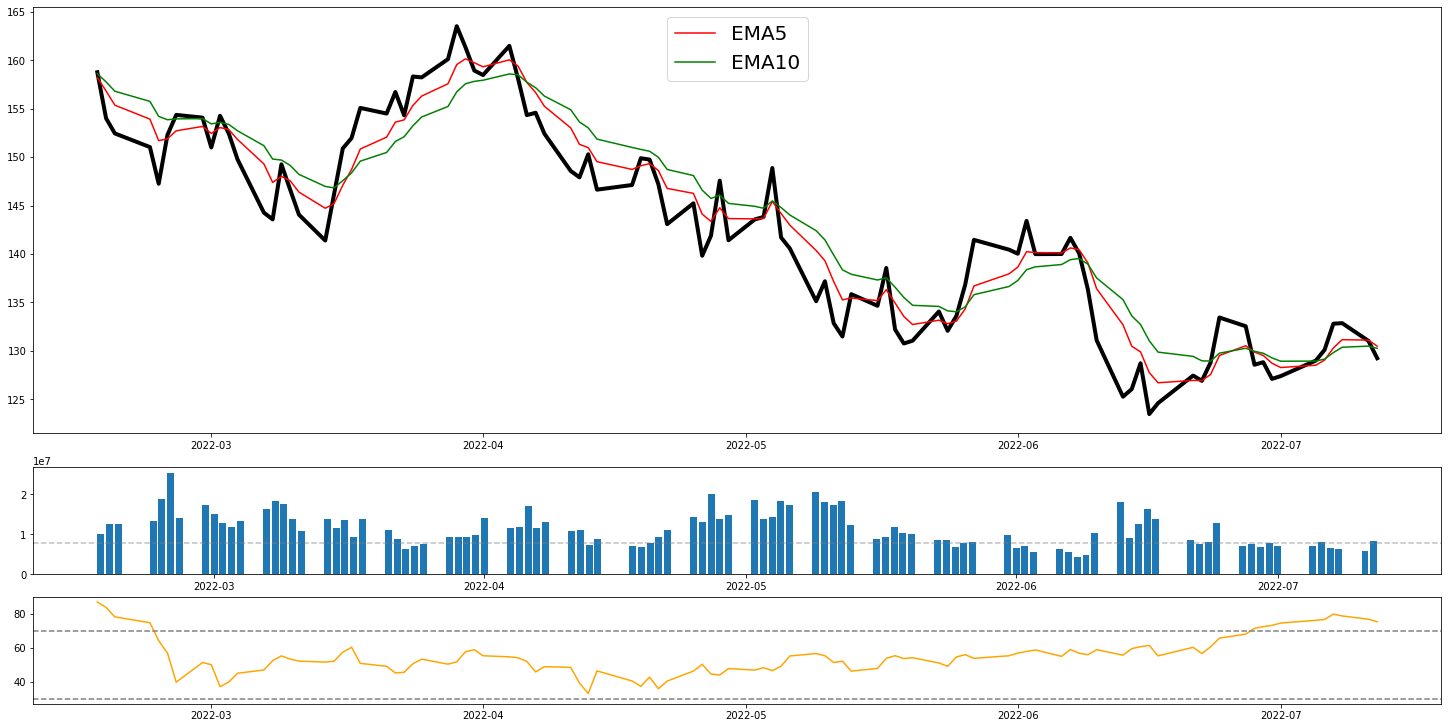

In [17]:
# plottinh using matplotlib 

ticker = input('sector ticker:').upper()

import matplotlib.gridspec as gridspec

#plt.rcParams['figure.figsize'] = [20, 40] # change the notebook's default
fig = plt.figure(constrained_layout=True, figsize=(20,10), facecolor='w') # change only this figure
gs = gridspec.GridSpec(6,4, fig)
ax_price = fig.add_subplot(gs[:4,:])
ax_vol = fig.add_subplot(gs[4,:])
ax_rsi = fig.add_subplot(gs[5,:])

x = hp_df[ticker]['date'].tail(100)
y_price = hp_df[ticker]['close'].tail(100)
y_EMA5 = hp_df[ticker]['EMA5'].tail(100)
y_EMA10 = hp_df[ticker]['EMA10'].tail(100)
y_vol = hp_df[ticker]['volume'].tail(100)
y_rsi = hp_df[ticker]['RSI'].tail(100)
ax_price.plot(x,y_price, color='black', linewidth=4)
ax_price.plot(x,y_EMA5, color='red', label='EMA5')
ax_price.plot(x,y_EMA10, color='green', label='EMA10')
ax_vol.bar(x,y_vol)
ax_vol.axhline(hp_df[ticker]['volume'].mean(), color='grey', linestyle='--', alpha=0.5)
ax_rsi.plot(x,y_rsi, color='orange')
ax_rsi.axhline(30, linestyle='--', color='grey')
ax_rsi.axhline(70, linestyle='--', color='grey')
ax_price.legend(loc='upper center', fontsize=20)

In [65]:
def chart(payload):
    
    ticker = input('ticker: ').upper()
    data_point = int(input('data points: '))
    data_point_by = input('data points by date (d) or minutes (m): ')
    
    handler = historicalPrice(ticker, payload=payload) # getting historically price
    handler = pd.json_normalize(handler, 'candles')
    
    #daily_datetime(handler) # ????????? checking this function for the correct date time ????????????
    percentChange(handler)
    
    # Indicators
    movingAverage(handler, 5, 'exponential')
    movingAverage(handler, 10, 'exponential')
    RSI(handler)
    
    
    # creating grids 6 by 4
    # plt.rcParams['figure.figsize'] = [20, 40] # change the notebook's default
    fig = plt.figure(constrained_layout=True, figsize=(20,10), facecolor='w') # setting for only this figure
    gs = gridspec.GridSpec(6,4, fig)
    
    # assigning subplot windows
    ax_price = fig.add_subplot(gs[:4,:])
    ax_vol = fig.add_subplot(gs[4,:])
    ax_rsi = fig.add_subplot(gs[5,:])
    
    if data_point_by == 'd':
        daily_datetime(handler)
        x = [f'{x:%Y-%m-%d}' for x in handler['date'].tail(data_point)]
    else:
        datetime_split(handler)
        x = [f'{str(x)}' for x in handler['time'].tail(data_point)]
    
    # assigning data for axes 
    y_price = handler['close'].tail(data_point)
    y_EMA5 = handler['EMA5'].tail(data_point)
    y_EMA10 = handler['EMA10'].tail(data_point)
    y_vol = handler['volume'].tail(data_point)
    y_rsi = handler['RSI'].tail(data_point)
    
    # creating price plot
    ax_price.plot(x,y_price, color='black', linewidth=4)
    ax_price.plot(x,y_EMA5, color='red', label='EMA5')
    ax_price.plot(x,y_EMA10, color='green', label='EMA10')
    ax_price.get_xaxis().set_visible(False)
    
    # creating volume plot
    ax_vol.bar(x,y_vol)
    ax_vol.get_xaxis().set_visible(False)
    ax_vol.axhline(handler['volume'].tail(data_point).mean(), color='grey', linestyle='--', alpha=0.5)
    
    # creating rsi plot
    ax_rsi.plot(x,y_rsi, color='orange')
    ax_rsi.axhline(30, linestyle='--', color='grey')
    ax_rsi.axhline(40, linestyle='--', color='grey', alpha=0.2)
    ax_rsi.axhline(50, linestyle='--', color='grey', alpha=0.2)
    ax_rsi.axhline(60, linestyle='--', color='grey', alpha=0.2)
    ax_rsi.axhline(70, linestyle='--', color='grey')
    ax_rsi.get_xaxis().set_visible(False)
    
    ax_price.legend(loc='upper center', fontsize=20)
    
    return handler

ticker: aapl
data points: 100
data points by date (d) or minutes (m): m


,open,high,low,close,volume,percent change,EMA5,EMA10,RSI,date,time
0,0.331250,0.335536,0.308214,0.312679,443492000,NaN,NaN,NaN,NaN,2002-07-11,22:00:00
1,0.311250,0.332143,0.300179,0.325536,295993600,4.11,NaN,NaN,NaN,2002-07-14,22:00:00
2,0.324107,0.331607,0.314464,0.318929,446768000,-2.03,NaN,NaN,NaN,2002-07-15,22:00:00
3,0.288036,0.289286,0.271250,0.279107,1215485600,-12.49,NaN,NaN,NaN,2002-07-16,22:00:00
4,0.276786,0.277857,0.263393,0.267679,559462400,-4.09,0.292414,NaN,NaN,2002-07-17,22:00:00
...,...,...,...,...,...,...,...,...,...,...,...
5030,141.355000,144.120000,141.080000,142.920000,74064254,0.96,140.593020,139.576694,52.594768,2022-07-05,22:00:00
5031,143.290000,146.550000,143.280000,146.350000,66253709,2.40,142.512013,140.808204,56.813035,2022-07-06,22:00:00
5032,145.265000,147.550000,145.000000,147.040000,64547798,0.47,144.021342,141.941258,57.629820,2022-07-07,22:00:00
5033,145.670000,146.640000,143.780000,144.870000,63305113,-1.48,144.304228,142.473756,54.160585,2022-07-10,22:00:00


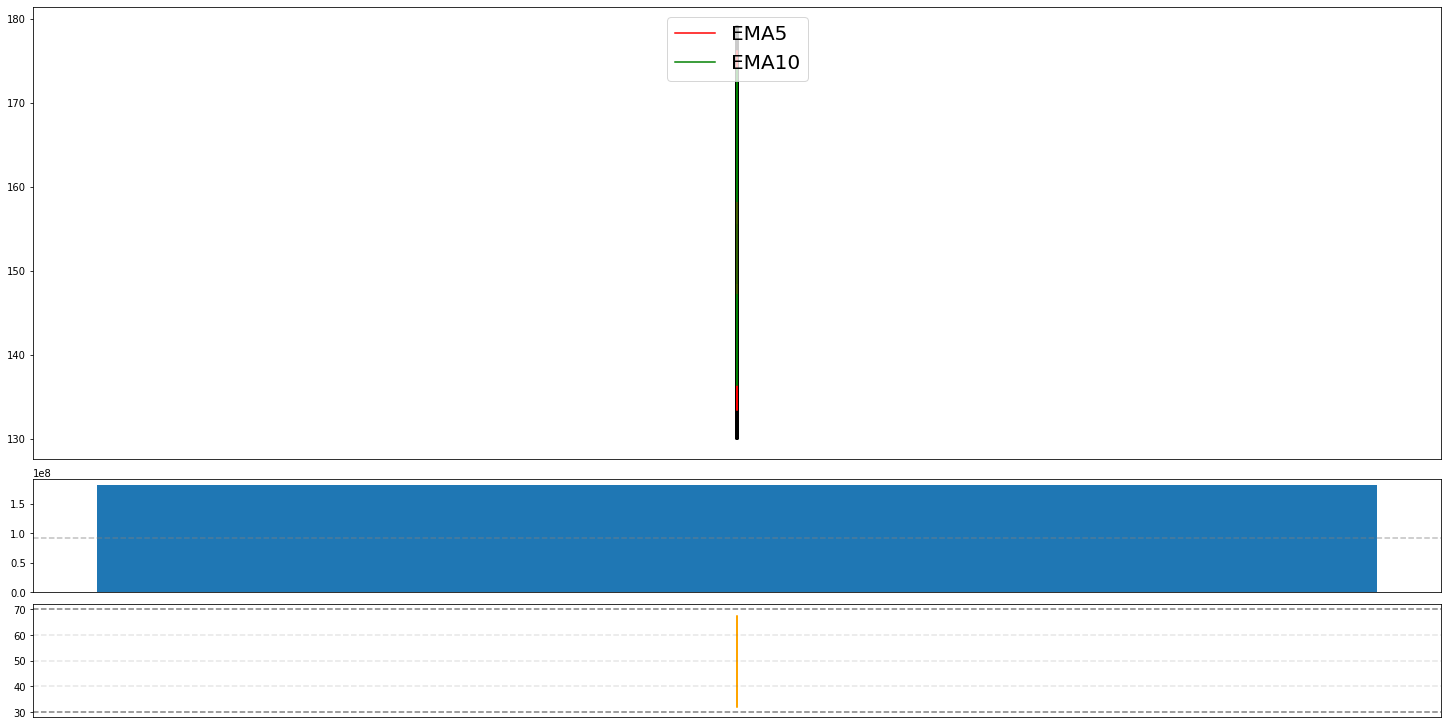

In [66]:
chart(payload_1d)

In [20]:
# relative volume up-tick and down-tick

payload_1m = {'apikey': api_key,
          'periodType': 'day',
          'period': '1',
          'frequencyType': 'minute',
          'frequency': '1'}

payload_5m = {'apikey': api_key,
          'periodType': 'day',
          'period': '1',
          'frequencyType': 'minute',
          'frequency': '5'}

def uptick_downtick(ticker, payload):
    
    handler = historicalPrice(ticker, payload=payload)
    handler = pd.json_normalize(handler, 'candles')
    datetime_split(handler)
    
    # compute the difference in open price and close price
    
    handler['open-close'] = (handler['open'].shift(1) + handler['close'].shift(1))/2 - (handler['open'] + handler['close'])/2
    
    # assign uptick and downtick 
    tick = [1 if item > 0 else -1 if item < 0 else 0 for item in handler['open-close']]
    handler['tick'] = pd.Series(tick)
    handler['index'] = pd.Series([i for i in range(1, len(tick)+1)])
    handler['rel_tick'] = -handler['tick']*np.log(handler['volume']/sum(handler['volume']))
    total_uptick = sum(handler[handler['tick'] > 0]['tick'])
    total_downtick = sum(handler[handler['tick'] < 0]['tick'])
    ratio = -round(total_uptick / total_downtick, 2)
    
    plt.figure(figsize=(20,10), facecolor='w')
    plt.bar(handler['index'],handler['rel_tick'])
    textbox = plt.text(0,0, f'Buy/Sell: {ratio}', fontsize = 20, color='black')
    textbox.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
            

    return handler
    
    

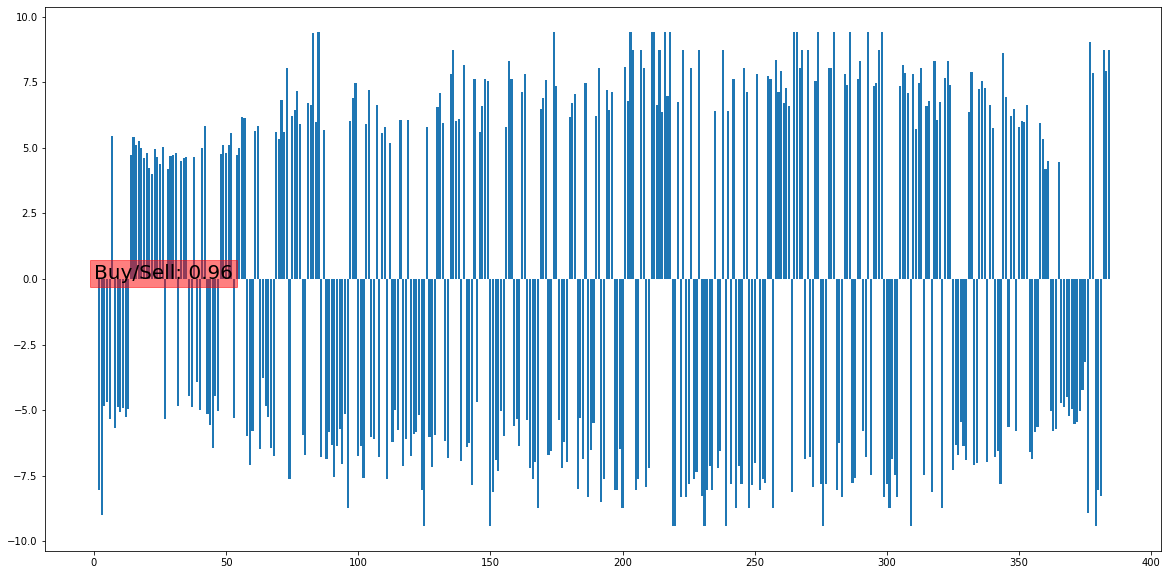

In [21]:
MDB = uptick_downtick('MDB', payload_1m)